In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
import h5py
from PIL import Image
import cv2


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset = h5py.File("/content/drive/MyDrive/MNIST_synthetic.h5","r")
dataset.keys()


<KeysViewHDF5 ['test_dataset', 'train_dataset', 'train_labels']>

## Preprocessing the dataset

In [ ]:

test_set = dataset['test_dataset'][:]
test_set = torch.from_numpy(test_set)
test_set= test_set.transpose(1, 2)
test_set= test_set.transpose(1, 3)

train_set = dataset['train_dataset'][:]
train_set = torch.from_numpy(train_set)
train_set= train_set.transpose(1, 2)
train_set= train_set.transpose(1, 3)


train_labels =  np.array(dataset['train_labels'][:])
print("testing set:",test_set.shape)
print("training set:",train_set.shape)
print("training set label:",train_labels.shape)


testing set: torch.Size([14000, 1, 64, 64])
training set: torch.Size([56000, 1, 64, 64])
training set label: (56000, 5)


In [ ]:
import cv2
def tensor_to_cv2(tensor):
    cv_image = tensor.numpy()
    cv_image = cv_image[0]
    return cv_image




### Show some images

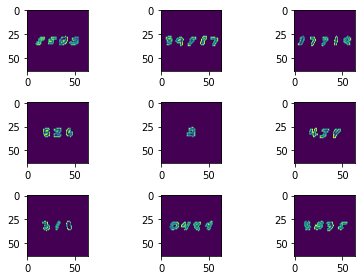

In [ ]:
Train_imgs = [] # temperary used
for i in range(9):
  tensor = train_set[i] *255
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  img = tensor_to_cv2(tensor)
  Train_imgs.append(img)
  plt.imshow(img)
plt.show()

### The function of dividing the dataset

In [ ]:
#input: 1 image
#output: 5 images(each image contains one digit) 

def grab_each_digit(cv_image):
    kernel = np.ones((3,3),np.uint8) 
    dilate = cv2.dilate(cv_image,kernel,iterations = 1) #dialation image
    binary_image = cv2.threshold(cv_image, 10, 255, 0)[1]
    contours = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
    borders = {}
    for contour in contours:
        #get the cordinates of the contour
        area = cv2.contourArea(contour)
        #print(area)
        if area>4: #threshold:We filter the noisy
          x,y,w,h = cv2.boundingRect(contour)
          borders[x] = [x, y, x+w, y+h]
    #print(borders)
    i=1
    images= np.zeros((5,28,28)) #use to store 5 images
    for key,value in sorted(borders.items()):
      part = cv_image[value[1]-1:value[3]+1,value[0]-1:value[2]+1]
      part = cv2.copyMakeBorder(part, 10, 10, 10, 10, cv2.BORDER_CONSTANT, value=0) #padding
      part = cv2.resize(part,(28,28)) #change image to 28*28 pixel 
      images[i-1]=part
      i+=1
      if i-1>=5:
        break
    if i-1<5:
        k=6-i
        while k>0:
            k=k-1
            blank=np.zeros((28,28))
            images[i-1]=blank
            i=i+1
    return images


#### 1st example of dividing a image

[ 8  5  0  3 10]


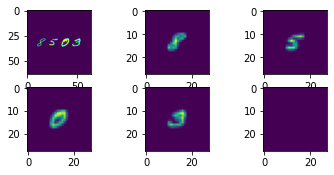

In [ ]:
firstImage = train_set[0] 
image = tensor_to_cv2(firstImage)
images = grab_each_digit(image)
plt.subplot(331)
plt.imshow(image) 
for i in range(len(images)):
  plt.subplot(3,3,i+2)
  plt.imshow(images[i])
print(train_labels[0])


#### 2nd example of dividing a image

[4 9 6 4 9]


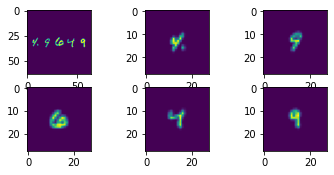

In [ ]:
secondImage = train_set[249]
image = tensor_to_cv2(secondImage)
images = grab_each_digit(image)
plt.subplot(331)
plt.imshow(image)
for i in range(len(images)):
  plt.subplot(3,3,i+2)
  plt.imshow(images[i])
print(train_labels[249])

#### Store the new image into a dataset

In [ ]:
image_set=[]
for row in train_set:
    image=row
    image2=tensor_to_cv2(image)
    images=grab_each_digit(image2)
    #print(images.shape)
    for image in images: #
      image_set.append(image)
image_set=np.array(image_set)
print(image_set.shape)

(280000, 28, 28)


#### Write the new dataset into a .h5 file

In [ ]:
new_train_labels= train_labels.reshape(56000*5)
#create h5 fil
hf = h5py.File('/content/drive/MyDrive/data.h5', 'w')
hf.create_dataset('single_digit', data=image_set)
hf.create_dataset('train_labels', data=new_train_labels)
hf.close()

## Training the dataset

In [ ]:
newdataset = h5py.File("/content/drive/MyDrive/data.h5","r")
newdataset.keys()

<KeysViewHDF5 ['single_digit', 'train_labels']>

In [ ]:
new_train_set = newdataset['single_digit'][:]
new_train_labels = newdataset['train_labels'][:]
print(new_train_labels.shape)
print(new_train_set.shape)
def show(pcol,prow,start):
  col,row =pcol,prow
  for i in range(1,len(new_train_set)):
    plt.subplot(col,row,i)
    plt.imshow(new_train_set[i-1+start])

    print(new_train_labels[i-1+start],end=' ')
    if i%5==0:
      print("")
    if i==col*row:
      break


(280000,)
(280000, 28, 28)


#### Show a part of the dataset

4 7 4 8 6 
5 5 5 10 10 
7 3 5 9 3 
7 6 10 10 10 


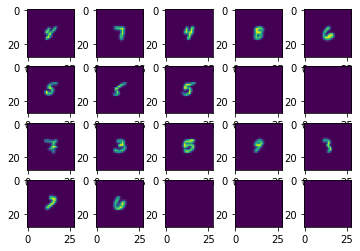

In [ ]:

show(4,5,2000)

#### Split the dataset into the validation and training set

In [ ]:
inds = np.random.permutation(280000)     
new_train_x=new_train_set[inds[:260000]]
new_train_y=new_train_labels[inds[:260000]]
new_test_x=new_train_set[inds[260000:280000]]
new_test_y=new_train_labels[inds[260000:280000]]
    
# new_train_x=new_train_set[:260000]
# new_train_y=new_train_labels[:260000]
# new_test_x=new_train_set[260000:280000]
# new_test_y=new_train_labels[260000:280000]
new_train_x = new_train_x.reshape((260000,1,28,28))
new_train_y=torch.tensor(new_train_y, dtype=torch.long) 
new_test_x = new_test_x.reshape((20000,1,28,28))
new_test_y=torch.tensor(new_test_y, dtype=torch.long) 

In [ ]:
class CustomedDataSet(torch.utils.data.Dataset):
    def __init__(self,train=True):
        self.train = train
        if self.train:
            trainX=new_train_x
            trainY=new_train_y
            self.datalist = trainX
            self.labellist = trainY
        else:
            testX=new_test_x
            testY=new_test_y
            self.datalist = testX
            self.labellist = testY
    def __getitem__(self, index):
        if self.train:
            return torch.Tensor(self.datalist[index].astype(float)),self.labellist[index]
        else:
            return torch.Tensor(self.datalist[index].astype(float)),self.labellist[index]
    def __len__(self):
        return self.datalist.shape[0]

#### Define the hyperparameter and the loader

In [ ]:
num_epochs = 10
batch_size = 100
learning_rate = 0.001
train_dataset = CustomedDataSet()
test_dataset = CustomedDataSet(train=False)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

#### Design the Convolutional Nerual Network Model (Choose one of them)

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1 ,16, kernel_size=5,padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
            
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5,padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
            
        self.fc = nn.Linear(7*7*32, 11)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

#### 3layers

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1 ,16, kernel_size=5,padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )
            
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5,padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
            
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5,padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2))
            
        self.fc = nn.Linear(7*7*64, 11)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

#### The Convolutional Nerual Network Model with dropout (Choose one of them)

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1 ,16, kernel_size=5,padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(p=0.5))
            
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5,padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(p=0.5))
            
        self.fc = nn.Linear(7*7*32, 11)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

#### load the model

In [ ]:
#cnn = CNN()
cnn= CNN()
cnn.load_state_dict(torch.load('/content/drive/MyDrive/net_best160.pth')) #load the previous trained model
cnn.train()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(),lr=learning_rate)

#### Do the Training!!!

In [ ]:
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader): 
        #Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = cnn(images)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        if (i+1) % 100 == 0:
          print("epoch",epoch, ":",i*batch_size/2600,"%")
          print("loss:",loss.data)
            ##print ('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f' %(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.data[0]))

epoch 0 : 3.8076923076923075 %
loss: tensor(0.0007)
epoch 0 : 7.653846153846154 %
loss: tensor(0.0001)
epoch 0 : 11.5 %
loss: tensor(9.3184e-05)
epoch 0 : 15.346153846153847 %
loss: tensor(0.0001)
epoch 0 : 19.192307692307693 %
loss: tensor(0.0001)
epoch 0 : 23.03846153846154 %
loss: tensor(0.0001)
epoch 0 : 26.884615384615383 %
loss: tensor(0.0002)
epoch 0 : 30.73076923076923 %
loss: tensor(0.0001)
epoch 0 : 34.57692307692308 %
loss: tensor(0.0005)
epoch 0 : 38.42307692307692 %
loss: tensor(0.0002)
epoch 0 : 42.26923076923077 %
loss: tensor(0.0055)
epoch 0 : 46.11538461538461 %
loss: tensor(0.0001)
epoch 0 : 49.96153846153846 %
loss: tensor(0.0001)
epoch 0 : 53.80769230769231 %
loss: tensor(0.0003)
epoch 0 : 57.65384615384615 %
loss: tensor(0.0006)
epoch 0 : 61.5 %
loss: tensor(4.6570e-05)
epoch 0 : 65.34615384615384 %
loss: tensor(0.0012)
epoch 0 : 69.1923076923077 %
loss: tensor(0.0017)
epoch 0 : 73.03846153846153 %
loss: tensor(0.0005)
epoch 0 : 76.88461538461539 %
loss: tensor(0.0

#### Save our trained model

In [ ]:

PATH = '/content/drive/MyDrive/net_best170.pth'
torch.save(cnn.state_dict(), PATH)

#### trainnig set accuracy

In [ ]:
correct = 0
total = 260000//5
train_wrong_list = []
new_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=5,
                                           shuffle=False,
                                           num_workers=2)
cnn.eval()
with torch.no_grad():
    for i, (images, labels) in enumerate(new_loader):
        outputs = cnn(images)
        _, predicted = torch.max(outputs.data, 1)
        if (predicted ==labels).sum().item()!=5:
          train_wrong_list.append(i)
        if (predicted ==labels).sum().item()==5:
          correct+=1
print('Accuracy of the network on the train images: %f %%' % (
    100 * correct / total))

Accuracy of the network on the train images: 99.813462 %


#### Validation set accuracy

In [ ]:
correct = 0
total = 20000//5
validate_wrong_list = []
new_test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=5,
                                          shuffle=False)
with torch.no_grad():
    for i, (images, labels) in enumerate(new_test_loader):
        outputs = cnn(images)
        _, predicted = torch.max(outputs.data, 1)
        if (predicted ==labels).sum().item()!=5:
          validate_wrong_list.append(i)
        if (predicted ==labels).sum().item()==5:
          correct+=1

print('Accuracy of the network on the validation images: %f %%' % (
    100 * correct / total))

Accuracy of the network on the validation images: 99.750000 %


In [ ]:
print(validate_wrong_list)

[536, 796, 1009, 1307, 2140, 2641, 2712, 2989, 3219, 3299]


##Prediction on the testing set

#### preprocessing the testing set

In [ ]:
dataset =h5py.File("/content/drive/MyDrive/MNIST_synthetic.h5","r")
dataset.keys()
test_set = dataset['test_dataset'][:]
test_set = torch.from_numpy(test_set)
test_set= test_set.transpose(1, 2)
test_set= test_set.transpose(1, 3)
image_set=[]
for i,row in enumerate(test_set):
    image=row
    image2=tensor_to_cv2(image)
    try:
      images=grab_each_digit(image2)
      for image in images: 
        image_set.append(image)
    except:
      print(i)

image_set=np.array(image_set)
print(image_set.shape)

(70000, 28, 28)


In [ ]:
image_set = image_set.reshape((70000, 1,28, 28))


#### predicting !!!

In [ ]:
test_loader2 = torch.utils.data.DataLoader(dataset=image_set,
                                          batch_size=5,
                                          shuffle=False)
prediction_list = []
with torch.no_grad():
    for i, images in enumerate(test_loader2):
        ##print(images.float().dtype)
        outputs = cnn(images.float())
        _, predicted = torch.max(outputs.data, 1)
        aPic = []
        for item in predicted:
          aPic.append(item.item())
        a = map(str, aPic)    
        string = ''.join(a)
        #print(string)
        prediction_list.append(string)



#### Show some of our prediction

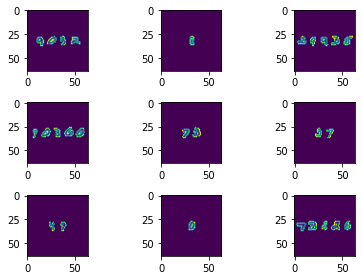

903210
810101010
29935
90360
73101010
37101010
49101010
010101010
73226


In [ ]:
#printing the result
Test_imgs = [] # temperary used
for i in range(9):
  tensor = test_set[i+240] *255
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  img = tensor_to_cv2(tensor)
  # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  Test_imgs.append(img)
  #img = img[20:40, 0:64] 
  plt.imshow(img)
plt.show()
for i in range(9):
  print(prediction_list[i+240])

#### Put the data into a csv file

In [ ]:
import pandas as pd
df = pd.DataFrame(prediction_list,columns=['Label'])

df.to_csv("/content/drive/MyDrive/result170.csv",index_label='Id')
